In [23]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

## Data -- Generation

In [24]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 2
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 25 unqiue cards
Generated 300 cardpairs
-- 100 cardpairs with shared concept
-- 200 cardpairs without shared concept
[(0, 200), (1, 100)]
Total number of matches =  500
Number of shared concepts per match =  [(1, 500)]


## Data -- Distribution, Splits

In [25]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [26]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1e-100, 7000), (0.002, 500)]

In [27]:
np.sum(count_table)

500.0

In [28]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 9
xy_div_xyind_rank= 9


In [29]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

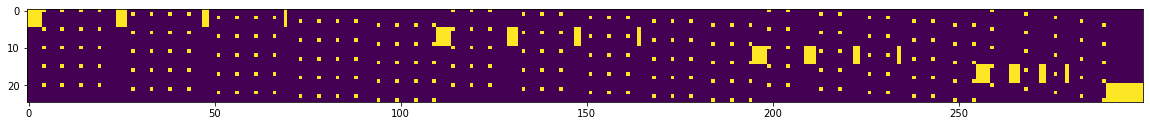

In [30]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

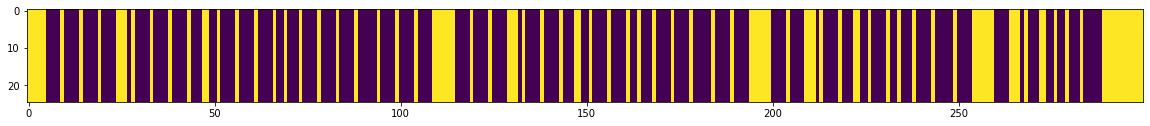

In [31]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

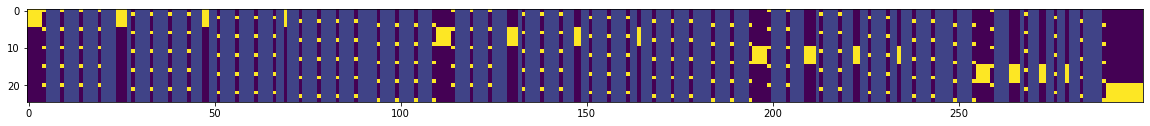

In [32]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

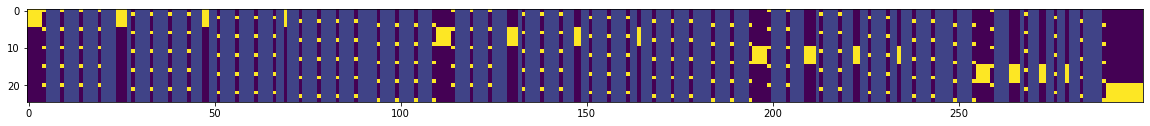

In [33]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [34]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999997, 3800),
 (2.5e-97, 1920),
 (0.9999999999999993, 1000),
 (5.0, 380),
 (0.9999999999999998, 200),
 (4.999999999999999, 100),
 (2.5000000000000003e-97, 80),
 (5.000000000000001, 20)]

## Dataset

In [35]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
key
 0 ('red', 'void')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
key
 0 ('red', 'void')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [36]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void') ('blue', 'dashed')
all matches 
 []
-----
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [37]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [38]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [39]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [40]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [41]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [42]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [43]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [44]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 230,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 74.8 K
1  | model.inp_query_layer                        | Sequential         | 69.0 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 69.0 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 69.0 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 5.8 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 5.8 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 5.8 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [45]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-45-a09c12e82836>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 74.8 K
1  | model.inp_query_layer                        | Sequential         | 69.0 K
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 69.0 K
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 69.0 K
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 5.8 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 5.8 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 5.8 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=9.37e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 13.34it/s, loss=9.37e+03, v_num=clfb]
                                                 

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=9.21e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=8.99e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=8.86e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=8.55e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=8.53e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=8.25e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=8.01e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=7.74e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=7.63e+03, v_num=clfb]
Validating: 0i

Epoch 42:  50%|█████     | 1/2 [00:00<00:00, 13.15it/s, loss=2.6e+03, v_num=clfb] 
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=2.49e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=2.39e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|█████     | 1/2 [00:00<00:00, 16.41it/s, loss=2.33e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 46:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=2.28e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 47:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=2.19e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=2.11e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 13.86it/s, loss=2.05e+03, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=1.99e+03, v_num=clfb]
Valid

Validating: 0it [00:00, ?it/s]
Epoch 84:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=863, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 85:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=849, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 86:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=847, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 87:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=832, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=833, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=825, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 90:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=817, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 91:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=804, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 92:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=795, v_num=clfb]
Validating: 0it [00

Epoch 126:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=667, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 127:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=666, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 128:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=666, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 129:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=668, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 130:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=666, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 135:

Epoch 169:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 178:

Epoch 211:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 212:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 213:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 214:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 215:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 216:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 217:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 220:

Epoch 254:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 255:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 256:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 257:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 263:

Epoch 296:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 297:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 298:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 299: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 300:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 301:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 305:

Epoch 339:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00, 14.07it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 345:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 346:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 347:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 348:

Epoch 381:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=666, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 382:  50%|█████     | 1/2 [00:00<00:00, 19.75it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 383:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 384:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 385:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 390:

Epoch 424:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 425:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 426:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 427:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 428:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 429:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 430:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=654, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 431:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 432:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 433:

Epoch 466:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 467:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 468:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 475:

Epoch 509:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 510:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 511:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 512:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=662, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 513:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 518:

Epoch 551:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 552:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 553:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 554:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 555:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 556:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 557:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 558:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 559:  50%|█████     | 1/2 [00:00<00:00, 18.77it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 560:

Epoch 594:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 595:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 596:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 597:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 598:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=654, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 599: 100%|██████████| 2/2 [00:00<00:00, 12.84it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 600:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 601:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 603:

Epoch 636:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=670, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 637:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=672, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 638:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=671, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=670, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=676, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=673, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=669, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=671, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=675, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 645:

Epoch 679:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 681:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 682:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 683:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=642, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 684:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|█████     | 1/2 [00:00<00:00, 16.50it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 688:

Epoch 721:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=665, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 722:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=664, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 723:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=664, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 724:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=665, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 725:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=667, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 726:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=664, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 727:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 728:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 729:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 730:

Epoch 764:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 765:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 766:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 767:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 768:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=662, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=657, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 773:

Epoch 806:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 815:

Epoch 849: 100%|██████████| 2/2 [00:00<00:00, 15.22it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 850:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 851:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 852:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 853:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 854:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 857:  50%|█████     | 1/2 [00:00<00:00, 14.79it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 858:

Epoch 891:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 892:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 893:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 894:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 895:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=664, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 896:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 897:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=668, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 898:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=666, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 899: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 900:

Epoch 934:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00, 13.18it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 943:

Epoch 976:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 977:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 978:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 979:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 980:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00, 13.14it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 983:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 984:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 985:

Validating: 0it [00:00, ?it/s]
Epoch 1019:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1020:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1021:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1022:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1023:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1024:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1025:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=642, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1026:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=643, v_num=clfb]
V

Epoch 1061:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=675, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1062:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=674, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1063:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=668, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1064:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=667, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1065:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=669, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=667, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00, 14.64it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1103:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1104:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1105:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=663, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|█████     | 1/2 [00:00<00:00, 18.83it/s, loss=661, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=660, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=659, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1145:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1146:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1147:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1148:  50%|█████     | 1/2 [00:00<00:00, 12.69it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1149: 100%|██████████| 2/2 [00:00<00:00, 15.04it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1150:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1151:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1152:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=652, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1153:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=656, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1187:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1188:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1189:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1190:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=641, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1191:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1192:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1193:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1195:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1229:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1230:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1231:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1232:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1271:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1274:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1277:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1278:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1313:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1314:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1315:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1316:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1320:  50%|█████     | 1/2 [00:00<00:00, 12.51it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1321:  50%|█████     | 1/2 [00:00<00:00, 14.38it/s, loss=641, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1355:  50%|█████     | 1/2 [00:00<00:00, 20.11it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1356:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=646, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1357:  50%|█████     | 1/2 [00:00<00:00, 16.55it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1358:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1359:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=641, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1360:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=642, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1362:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1397:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=658, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=655, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s, loss=653, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=648, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00, 16.18it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=642, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1439:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1440:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1441:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1442:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|█████     | 1/2 [00:00<00:00, 17.48it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1447:  50%|█████     | 1/2 [00:00<00:00, 19.67it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1481:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1482:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1483:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1484:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████     | 1/2 [00:00<00:00, 15.45it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1523:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1524:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1525:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1526:  50%|█████     | 1/2 [00:00<00:00, 20.07it/s, loss=637, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|█████     | 1/2 [00:00<00:00, 16.54it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1565:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1571:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1572:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1607:  50%|█████     | 1/2 [00:00<00:00, 16.37it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1608:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1609:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1610:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1615:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1649: 100%|██████████| 2/2 [00:00<00:00, 15.52it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1650:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1651:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1652:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1653:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1654:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1655:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1656:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1657:  50%|█████     | 1/2 [00:00<00:00, 15.55it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1691:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1692:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1693:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1694:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=640, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1733:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1737:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1738:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1739:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=641, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1740:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=639, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=636, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1775:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1776:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=647, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1777:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1778:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=650, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1781:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=644, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1782:  50%|█████     | 1/2 [00:00<00:00, 20.31it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1783:  50%|█████     | 1/2 [00:00<00:00, 12.72it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1817:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1818:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1819:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1820:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1821:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1822:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1823:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1824:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1825:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1859:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=627, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1901:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1902:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1903:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1904:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=635, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=638, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=643, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=645, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1908:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=649, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1909:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=651, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1943:  50%|█████     | 1/2 [00:00<00:00, 16.49it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1944:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1945:  50%|█████     | 1/2 [00:00<00:00, 17.34it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1946:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1947:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1948:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1949: 100%|██████████| 2/2 [00:00<00:00, 13.42it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1950:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1951:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 1985:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1986:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1987:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1988:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1989:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1990:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1991:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2027:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2033:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2034:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2069:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=614, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2070:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2071:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2072:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=620, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2077:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=621, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2111:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2112:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2113:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2114:  50%|█████     | 1/2 [00:00<00:00, 17.66it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2115:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2116:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2117:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2118:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2119:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2153:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2154:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2155:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2156:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=614, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2195:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2198:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2199: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2200:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2201:  50%|█████     | 1/2 [00:00<00:00, 20.68it/s, loss=629, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2202:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2237:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2238:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2239:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2240:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2241:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2245:  50%|█████     | 1/2 [00:00<00:00, 15.11it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2279:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2280:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=628, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2281:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2282:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2283:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2284:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2285:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2286:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2287:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2321:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00, 16.42it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=614, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2363:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2364:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=633, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2365:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=632, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2366:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2367:  50%|█████     | 1/2 [00:00<00:00, 18.87it/s, loss=631, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2368:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2369:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2370:  50%|█████     | 1/2 [00:00<00:00, 13.42it/s, loss=630, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2371:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=634, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2405:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2406:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2407:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2408:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2409:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2410:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2411:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2412:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2413:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2447:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=614, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2448:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2449: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2450:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2451:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2489:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2496:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2497:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2531:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2532:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2533:  50%|█████     | 1/2 [00:00<00:00, 16.77it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2534:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2535:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2536:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2537:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2538:  50%|█████     | 1/2 [00:00<00:00, 12.38it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2539:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2573:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2574:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2575:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2576:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2577:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2578:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2579:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2580:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2581:  50%|█████     | 1/2 [00:00<00:00, 20.12it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2615:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2616:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2617:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2618:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2657:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=622, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2661:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2662:  50%|█████     | 1/2 [00:00<00:00, 14.67it/s, loss=624, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2663:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=623, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2664:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2665:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=626, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2699: 100%|██████████| 2/2 [00:00<00:00, 14.88it/s, loss=625, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2700:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=618, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2701:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=619, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2702:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=617, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2703:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2704:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2705:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2706:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2707:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=616, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2741:  50%|█████     | 1/2 [00:00<00:00, 19.92it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2742:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2743:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2744:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2745:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2746:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2747:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2748:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s, loss=612, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2783:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00, 19.58it/s, loss=605, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=604, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=603, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00, 14.54it/s, loss=604, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2825:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2826:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2827:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2828:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2829:  50%|█████     | 1/2 [00:00<00:00, 14.26it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2830:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2831:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2832:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2833:  50%|█████     | 1/2 [00:00<00:00, 15.92it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2867:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=603, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2868:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2869:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2870:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2871:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2872:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2873:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2874:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2909:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=604, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2910:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2911:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2912:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2913:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2915:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2951:  50%|█████     | 1/2 [00:00<00:00, 14.45it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2958:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2959:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 2993:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2994:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=605, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2995:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2996:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=601, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2997:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2998:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 2999: 100%|██████████| 2/2 [00:00<00:00, 13.60it/s, loss=603, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3000:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=603, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3001:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3035:  50%|█████     | 1/2 [00:00<00:00, 12.63it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3036:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3037:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3038:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3039:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3040:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=611, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3041:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=613, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=614, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3043:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=615, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3077:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3078:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3079:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3080:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3119:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00, 12.89it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3122:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3123:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3124:  50%|█████     | 1/2 [00:00<00:00, 12.81it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3125:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3126:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3127:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3161:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3162:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3163:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3164:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3165:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3166:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3167:  50%|█████     | 1/2 [00:00<00:00, 17.44it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3168:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3169:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3203:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3204:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3205:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3206:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3208:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3209:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3210:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3245:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00, 16.54it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00, 13.21it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3287:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3288:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3289:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3290:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3291:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3292:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3293:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3294:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3295:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=610, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3329:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3330:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3331:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3332:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3333:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3334:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3335:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3336:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3337:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3371:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3372:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3373:  50%|█████     | 1/2 [00:00<00:00, 12.58it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3374:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3375:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00, 15.26it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3377:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00, 15.79it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3413:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00, 18.77it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3420:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3421:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3455:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3456:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3457:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3458:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3459:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3460:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3461:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3462:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3463:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3497:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3498:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3499: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3500:  50%|█████     | 1/2 [00:00<00:00, 17.08it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3501:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3502:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3503:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3504:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3505:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3539:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3540:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3541:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3542:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00, 19.70it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3581:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00, 15.61it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3584:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3585:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3586:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3587:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3588:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3589:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3623:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3624:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3625:  50%|█████     | 1/2 [00:00<00:00, 18.72it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3626:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3627:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3628:  50%|█████     | 1/2 [00:00<00:00, 12.66it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3629:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3630:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3631:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3665:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3666:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3667:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3668:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3669:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3670:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3671:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3672:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3673:  50%|█████     | 1/2 [00:00<00:00, 18.83it/s, loss=597, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3707:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3749: 100%|██████████| 2/2 [00:00<00:00, 15.36it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3750:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=607, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3751:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3752:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=604, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3753:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=604, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3754:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3755:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=609, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3756:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=606, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3757:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=608, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3791:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3792:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3793:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=598, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3794:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3795:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=599, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3796:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3797:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3798:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=600, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3799: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s, loss=602, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3833:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3834:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3835:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3836:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3837:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3838:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3839:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3875:  50%|█████     | 1/2 [00:00<00:00, 20.18it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3917:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3918:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3919:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3920:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3921:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3922:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3923:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3924:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3925:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 3959:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3960:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3961:  50%|█████     | 1/2 [00:00<00:00, 11.66it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3962:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3963:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3964:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3965:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3966:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 3967:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4001:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4002:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4003:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4004:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00, 17.09it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4043:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4046:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4085:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4086:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4087:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4088:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4089:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4090:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4091:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4092:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4093:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4127:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4128:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4129:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4130:  50%|█████     | 1/2 [00:00<00:00, 12.86it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4131:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4132:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4133:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4134:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4135:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4169:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00, 19.59it/s, loss=596, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=594, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4174: 100%|██████████| 2/2 [00:00<00:00, 18.33it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=592, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=595, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=593, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4211:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4212:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4213:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4214:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4215:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4216:  50%|█████     | 1/2 [00:00<00:00, 18.85it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4217:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4218:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4219:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4253:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4254:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4255:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4256:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4257:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4258:  50%|█████     | 1/2 [00:00<00:00, 15.74it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4259:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4260:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4261:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4295:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4296:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4297:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4298:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4299: 100%|██████████| 2/2 [00:00<00:00, 13.57it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4300:  50%|█████     | 1/2 [00:00<00:00, 15.14it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4301:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4337:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=591, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=590, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4379:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4380:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4381:  50%|█████     | 1/2 [00:00<00:00, 14.16it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4382:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4383:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4384:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4385:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4386:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4387:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=576, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4421:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4422:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4423:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4424:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4425:  50%|█████     | 1/2 [00:00<00:00, 16.50it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4426:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4427:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4428:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4429:  50%|█████     | 1/2 [00:00<00:00, 15.54it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4463:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=575, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4464:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4465:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4466:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4505:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00, 18.72it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=586, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4547:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4548:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4549: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4550:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4551:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4552:  50%|█████     | 1/2 [00:00<00:00, 17.09it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4553:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4554:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4555:  50%|█████     | 1/2 [00:00<00:00, 16.31it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4589:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4590:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4591:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4592:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4593:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4594:  50%|█████     | 1/2 [00:00<00:00, 15.95it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4595:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4596:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4597:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4631:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4632:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00, 15.31it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00, 15.86it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=573, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4673:  50%|█████     | 1/2 [00:00<00:00, 12.54it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4674:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=583, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4675:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=584, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4676:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=585, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=588, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=587, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=589, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4715:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4716:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4717:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4718:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4719:  50%|█████     | 1/2 [00:00<00:00, 16.55it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4720:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4721:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4722:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4723:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4757:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4758:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4759:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4760:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4761:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=582, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4762:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4763:  50%|█████     | 1/2 [00:00<00:00, 16.04it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4799: 100%|██████████| 2/2 [00:00<00:00, 13.40it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00, 13.81it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4806:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=574, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=572, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4841:  50%|█████     | 1/2 [00:00<00:00, 13.32it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4842:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4843:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4844:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4847:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4848:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4849: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4883:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4884:  50%|█████     | 1/2 [00:00<00:00, 13.92it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4885:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4886:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4887:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4888:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4889:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4890:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4891:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4925:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4926:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4927:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4928:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00, 20.05it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00, 16.00it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00, 19.59it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 4967:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4970:  50%|█████     | 1/2 [00:00<00:00, 16.77it/s, loss=562, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4971:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5009:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=580, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5010:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5011:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5012:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5013:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=581, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5014:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5015:  50%|█████     | 1/2 [00:00<00:00, 19.08it/s, loss=579, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5016:  50%|█████     | 1/2 [00:00<00:00, 14.73it/s, loss=577, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5017:  50%|█████     | 1/2 [00:00<00:00, 15.70it/s, loss=578, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5051:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5052:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5053:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5054:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5055:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5056:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5057:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5058:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5059:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5093:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5094:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00, 12.90it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00, 15.18it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5135:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5136:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=550, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5137:  50%|█████     | 1/2 [00:00<00:00, 13.54it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5138:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5139:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5140:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5141:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5142:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5143:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5177:  50%|█████     | 1/2 [00:00<00:00, 19.13it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5178:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5179:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5180:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5181:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5182:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5183:  50%|█████     | 1/2 [00:00<00:00, 20.16it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5184:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5185:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5219:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5220:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5221:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5222:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5223:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5224:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5225:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=570, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5261:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5267:  50%|█████     | 1/2 [00:00<00:00, 17.08it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5268:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5269:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5303:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5304:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5305:  50%|█████     | 1/2 [00:00<00:00, 16.22it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5306:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5307:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5308:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=550, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5309:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5310:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5311:  50%|█████     | 1/2 [00:00<00:00, 15.65it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5345:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5346:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=571, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5347:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5348:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5349: 100%|██████████| 2/2 [00:00<00:00, 13.66it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5350:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5351:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5352:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5353:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5387:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5388:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5389:  50%|█████     | 1/2 [00:00<00:00, 14.49it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5390:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5391:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5429:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5432:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5433:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5434:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5435:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5436:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5437:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5471:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5472:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5473:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5474:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5475:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5476:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5477:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5478:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=550, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5479:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5513:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5514:  50%|█████     | 1/2 [00:00<00:00, 13.31it/s, loss=568, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5515:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=566, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5516:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5517:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5518:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=567, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5519:  50%|█████     | 1/2 [00:00<00:00, 13.49it/s, loss=569, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5520:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5521:  50%|█████     | 1/2 [00:00<00:00, 15.66it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5555:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5556:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5557:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5558:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00, 15.92it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5597:  50%|█████     | 1/2 [00:00<00:00, 16.37it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5598:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5599: 100%|██████████| 2/2 [00:00<00:00, 13.89it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5600:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5601:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5602:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5603:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5604:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5605:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5639:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5640:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5641:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5642:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5643:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5644:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5645:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5646:  50%|█████     | 1/2 [00:00<00:00, 16.31it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5647:  50%|█████     | 1/2 [00:00<00:00, 15.44it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5681:  50%|█████     | 1/2 [00:00<00:00, 12.90it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5682:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5683:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5684:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5685:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5686:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5687:  50%|█████     | 1/2 [00:00<00:00, 14.76it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5723:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5724:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5725:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5726:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5729:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5730:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5731:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5765:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5766:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5767:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5768:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5769:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5770:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5771:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5772:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5773:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5807:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5808:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5809:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5810:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5811:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5812:  50%|█████     | 1/2 [00:00<00:00, 13.69it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5813:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5814:  50%|█████     | 1/2 [00:00<00:00, 16.30it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5815:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5849: 100%|██████████| 2/2 [00:00<00:00, 13.13it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5850:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5851:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5852:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=556, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=552, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5891:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5894:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5895:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5896:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5897:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5898:  50%|█████     | 1/2 [00:00<00:00, 15.57it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5899: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5933:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5934:  50%|█████     | 1/2 [00:00<00:00, 17.51it/s, loss=555, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5935:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=557, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5936:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=553, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5937:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=554, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5938:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5939:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5940:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5941:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 5975:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5976:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5977:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5978:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5979:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5980:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5981:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5982:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 5983:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6017:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6018:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=551, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00, 16.31it/s, loss=549, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=550, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00, 13.70it/s, loss=550, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6059:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6060:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6061:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6062:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6063:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6064:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6065:  50%|█████     | 1/2 [00:00<00:00, 13.11it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6066:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6067:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6101:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6102:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6103:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6104:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6105:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6106:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6107:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6108:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6109:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6143:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6144:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6145:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6146:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6147:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6148:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6149: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6185:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=564, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00, 13.00it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=565, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=562, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=563, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6191:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=562, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6192:  50%|█████     | 1/2 [00:00<00:00, 12.36it/s, loss=562, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6193:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6227:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6228:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6229:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6230:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6231:  50%|█████     | 1/2 [00:00<00:00, 12.98it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6232:  50%|█████     | 1/2 [00:00<00:00, 16.91it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6233:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6234:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6235:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6269:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=548, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6270:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=545, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6271:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6272:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6273:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6274:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6275:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6276:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6277:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6311:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6312:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6313:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6314:  50%|█████     | 1/2 [00:00<00:00, 12.67it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00, 15.30it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6353:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=558, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6357:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=559, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6358:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6359:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=560, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6360:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=562, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6361:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=561, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6395:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6396:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6397:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6398:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6399: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6400:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6401:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6402:  50%|█████     | 1/2 [00:00<00:00, 15.47it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6403:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6437:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6438:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6439:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6440:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6441:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6442:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6443:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6444:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6445:  50%|█████     | 1/2 [00:00<00:00, 16.68it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6479:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6480:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6481:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6482:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6521:  50%|█████     | 1/2 [00:00<00:00, 13.59it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6522:  50%|█████     | 1/2 [00:00<00:00, 15.48it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6523:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6524:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6525:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6526:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6527:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6528:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6529:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6563:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6564:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6565:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6566:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6567:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6568:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=547, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6569:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=546, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6570:  50%|█████     | 1/2 [00:00<00:00, 14.77it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6571:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=544, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6605:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6606:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6607:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6608:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6609:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6610:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6611:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6647:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6648:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6649: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6650:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6653:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6654:  50%|█████     | 1/2 [00:00<00:00, 16.00it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6655:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6689:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6690:  50%|█████     | 1/2 [00:00<00:00, 15.73it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6691:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=542, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6692:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=543, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6693:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=541, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6695:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6696:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6697:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6731:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6732:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6733:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6734:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6735:  50%|█████     | 1/2 [00:00<00:00, 16.37it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6736:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6737:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6738:  50%|█████     | 1/2 [00:00<00:00, 18.72it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6739:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6773:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6774:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6775:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6776:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6777:  50%|█████     | 1/2 [00:00<00:00, 15.05it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6815:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=540, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=539, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6818:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=538, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6819:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6820:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=537, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6821:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6822:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6823:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6857:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6858:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6859:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6860:  50%|█████     | 1/2 [00:00<00:00, 19.11it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6861:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6862:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6863:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6864:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6865:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6899: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6900:  50%|█████     | 1/2 [00:00<00:00, 13.47it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6901:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6902:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6903:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6904:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6905:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6906:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6907:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6941:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6942:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=534, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6943:  50%|█████     | 1/2 [00:00<00:00, 16.55it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=535, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00, 12.87it/s, loss=536, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00, 15.95it/s, loss=533, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 6983:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6984:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=532, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6985:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6986:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6987:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6988:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6989:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6990:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 6991:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7025:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7026:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7027:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7028:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7029:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7030:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7031:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7032:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7033:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7067:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7068:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7069:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7070:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7071:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7072:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7073:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7109:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7110:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7115:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7116:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7117:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7151:  50%|█████     | 1/2 [00:00<00:00, 14.01it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7152:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7153:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7154:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7155:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7156:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7157:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7158:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7159:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=531, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7193:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7194:  50%|█████     | 1/2 [00:00<00:00, 14.91it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7195:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7196:  50%|█████     | 1/2 [00:00<00:00, 19.76it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7197:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7198:  50%|█████     | 1/2 [00:00<00:00, 16.77it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7199: 100%|██████████| 2/2 [00:00<00:00, 14.15it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7200:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7201:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7235:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7236:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7237:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7238:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7239:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7240:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00, 15.89it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00, 15.96it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7277:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7280:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7281:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7282:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7283:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7284:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7285:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7319:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7320:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7321:  50%|█████     | 1/2 [00:00<00:00, 14.52it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7322:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7323:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7324:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7325:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7326:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7327:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=530, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7361:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7362:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7363:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7364:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7365:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7366:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7367:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=524, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7368:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=525, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7369:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7403:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7404:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7405:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00, 15.85it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=523, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7445:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7446:  50%|█████     | 1/2 [00:00<00:00, 19.20it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7447:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7448:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7449: 100%|██████████| 2/2 [00:00<00:00, 14.00it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7450:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7451:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7452:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7453:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7487:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7488:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7489:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7490:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=529, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7491:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7492:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7493:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=527, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7494:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=528, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7495:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=526, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7529:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7530:  50%|█████     | 1/2 [00:00<00:00, 15.82it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7531:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7532:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7533:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7534:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7535:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00, 13.34it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7571:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7572:  50%|█████     | 1/2 [00:00<00:00, 13.77it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7573:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7574:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7577:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7578:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7579:  50%|█████     | 1/2 [00:00<00:00, 16.22it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7613:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7614:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7615:  50%|█████     | 1/2 [00:00<00:00, 19.50it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7616:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7617:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7618:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7619:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7620:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7621:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7655:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7656:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7657:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7658:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7659:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7660:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7661:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7662:  50%|█████     | 1/2 [00:00<00:00, 15.28it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7663:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7697:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7698:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7699: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7700:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7701:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7702:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00, 13.50it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7739:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=522, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7740:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=521, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7741:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7742:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7743:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7744:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7745:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7746:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7747:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7781:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7782:  50%|█████     | 1/2 [00:00<00:00, 14.37it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7783:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7784:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7785:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7786:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7787:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7788:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7789:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7823:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7824:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7825:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7826:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7827:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=512, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7828:  50%|█████     | 1/2 [00:00<00:00, 16.02it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7829:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7830:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7831:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7865:  50%|█████     | 1/2 [00:00<00:00, 16.27it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7866:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7867:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00, 12.75it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7907:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7908:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7909:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7910:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7911:  50%|█████     | 1/2 [00:00<00:00, 19.93it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7912:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7913:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7914:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=512, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7915:  50%|█████     | 1/2 [00:00<00:00, 14.78it/s, loss=513, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7949: 100%|██████████| 2/2 [00:00<00:00, 15.13it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7950:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7951:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7952:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7953:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7954:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7955:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7956:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7957:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 7991:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7992:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7993:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7994:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7995:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7996:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7997:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 7999: 100%|██████████| 2/2 [00:00<00:00, 12.96it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8033:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8034:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8035:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8039:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8040:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8041:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8075:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8076:  50%|█████     | 1/2 [00:00<00:00, 13.76it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8077:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8078:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=520, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8079:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=519, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8080:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=518, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8081:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=516, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8082:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8083:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=514, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8117:  50%|█████     | 1/2 [00:00<00:00, 17.34it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8118:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8119:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8120:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8121:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8122:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8123:  50%|█████     | 1/2 [00:00<00:00, 17.10it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8124:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8125:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8159:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8160:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8161:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8162:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00, 13.90it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00, 14.28it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8201:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8202:  50%|█████     | 1/2 [00:00<00:00, 14.86it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8203:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8204:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8205:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8206:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8207:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8208:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8209:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8243:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8244:  50%|█████     | 1/2 [00:00<00:00, 16.78it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8245:  50%|█████     | 1/2 [00:00<00:00, 15.07it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8246:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8247:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8248:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8249: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8250:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8251:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8285:  50%|█████     | 1/2 [00:00<00:00, 14.15it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8286:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8287:  50%|█████     | 1/2 [00:00<00:00, 16.15it/s, loss=512, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8288:  50%|█████     | 1/2 [00:00<00:00, 15.40it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8289:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8290:  50%|█████     | 1/2 [00:00<00:00, 14.90it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8291:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8292:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8293:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=512, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8327:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=517, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8328:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=515, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=512, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00, 16.06it/s, loss=510, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8369:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8370:  50%|█████     | 1/2 [00:00<00:00, 12.57it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8371:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8372:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8373:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8374:  50%|█████     | 1/2 [00:00<00:00, 19.37it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8375:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8376:  50%|█████     | 1/2 [00:00<00:00, 12.88it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8377:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8411:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8412:  50%|█████     | 1/2 [00:00<00:00, 12.77it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8413:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8414:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8415:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8416:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8417:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8418:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=511, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8419:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=509, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8453:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8454:  50%|█████     | 1/2 [00:00<00:00, 14.41it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8455:  50%|█████     | 1/2 [00:00<00:00, 17.34it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8456:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8457:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8458:  50%|█████     | 1/2 [00:00<00:00, 20.08it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8459:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00, 19.91it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8495:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=508, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8496:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8497:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8499: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8501:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8502:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8503:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=504, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8537:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8538:  50%|█████     | 1/2 [00:00<00:00, 14.60it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8539:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8540:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8541:  50%|█████     | 1/2 [00:00<00:00, 15.15it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8542:  50%|█████     | 1/2 [00:00<00:00, 13.71it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8543:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8544:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8545:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8579:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8580:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8581:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8582:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8583:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8584:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8585:  50%|█████     | 1/2 [00:00<00:00, 13.82it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8586:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8587:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8621:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8622:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8623:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8624:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00, 17.40it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8663:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00, 15.06it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8666:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8667:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8668:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8669:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=505, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8670:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=507, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8671:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=506, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8705:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8706:  50%|█████     | 1/2 [00:00<00:00, 19.30it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8707:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8708:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8709:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8710:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8711:  50%|█████     | 1/2 [00:00<00:00, 19.54it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8712:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8713:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8747:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8748:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8749: 100%|██████████| 2/2 [00:00<00:00, 15.58it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8750:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8751:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8752:  50%|█████     | 1/2 [00:00<00:00, 12.95it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8753:  50%|█████     | 1/2 [00:00<00:00, 17.08it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8754:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8755:  50%|█████     | 1/2 [00:00<00:00, 13.38it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8789:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8790:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8791:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00, 14.69it/s, loss=503, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00, 16.39it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=502, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8831:  50%|█████     | 1/2 [00:00<00:00, 20.66it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8832:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8833:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8834:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8835:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8836:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8837:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8838:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8839:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8873:  50%|█████     | 1/2 [00:00<00:00, 14.08it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8874:  50%|█████     | 1/2 [00:00<00:00, 14.24it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8875:  50%|█████     | 1/2 [00:00<00:00, 16.77it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8876:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8877:  50%|█████     | 1/2 [00:00<00:00, 13.79it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8878:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8879:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8880:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8881:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8915:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8916:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8917:  50%|█████     | 1/2 [00:00<00:00, 15.94it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8918:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8919:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8920:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8921:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00, 15.12it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8957:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8958:  50%|█████     | 1/2 [00:00<00:00, 15.81it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00, 12.99it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00, 16.51it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8964:  50%|█████     | 1/2 [00:00<00:00, 15.38it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 8965:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 8999: 100%|██████████| 2/2 [00:00<00:00, 11.57it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9000:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9001:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9002:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9003:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9004:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9005:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9006:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9007:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9041:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9042:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9043:  50%|█████     | 1/2 [00:00<00:00, 13.78it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9044:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9045:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9046:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9047:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9048:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9049: 100%|██████████| 2/2 [00:00<00:00, 15.51it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9083:  50%|█████     | 1/2 [00:00<00:00, 14.27it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9084:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9085:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9086:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9087:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9088:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=501, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9089:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00, 14.88it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9125:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=500, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9128:  50%|█████     | 1/2 [00:00<00:00, 12.48it/s, loss=499, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=498, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00, 13.80it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9132:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9133:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9167:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9168:  50%|█████     | 1/2 [00:00<00:00, 20.29it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9169:  50%|█████     | 1/2 [00:00<00:00, 19.36it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9170:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9171:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9172:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9173:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9174:  50%|█████     | 1/2 [00:00<00:00, 16.18it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9175:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9209:  50%|█████     | 1/2 [00:00<00:00, 16.75it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9210:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=497, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9211:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9212:  50%|█████     | 1/2 [00:00<00:00, 13.39it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9213:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9214:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9215:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=495, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9216:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9217:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=496, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9251:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9252:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9253:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9254:  50%|█████     | 1/2 [00:00<00:00, 15.59it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=492, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9293:  50%|█████     | 1/2 [00:00<00:00, 18.29it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9294:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=494, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9295:  50%|█████     | 1/2 [00:00<00:00, 14.22it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00, 14.56it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9298:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9299: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9300:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9301:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9335:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9336:  50%|█████     | 1/2 [00:00<00:00, 15.22it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9337:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9338:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9339:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9340:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9341:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9342:  50%|█████     | 1/2 [00:00<00:00, 14.30it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9343:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9377:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9378:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9379:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9380:  50%|█████     | 1/2 [00:00<00:00, 13.83it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9381:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9382:  50%|█████     | 1/2 [00:00<00:00, 13.05it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9383:  50%|█████     | 1/2 [00:00<00:00, 17.39it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9385:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9419:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9420:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=493, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9421:  50%|█████     | 1/2 [00:00<00:00, 16.75it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9422:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9423:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9425:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9461:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9462:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9463:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9466:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9467:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9468:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9469:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9503:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9504:  50%|█████     | 1/2 [00:00<00:00, 15.41it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9505:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9506:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9507:  50%|█████     | 1/2 [00:00<00:00, 13.28it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9508:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9509:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9510:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9511:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9545:  50%|█████     | 1/2 [00:00<00:00, 13.75it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9546:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9547:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9548:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9549: 100%|██████████| 2/2 [00:00<00:00, 13.22it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9550:  50%|█████     | 1/2 [00:00<00:00, 19.81it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9551:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9552:  50%|█████     | 1/2 [00:00<00:00, 15.51it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9553:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9587:  50%|█████     | 1/2 [00:00<00:00, 15.77it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9588:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9589:  50%|█████     | 1/2 [00:00<00:00, 17.96it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9590:  50%|█████     | 1/2 [00:00<00:00, 16.60it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9591:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00, 14.10it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00, 14.36it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=486, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9629:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9630:  50%|█████     | 1/2 [00:00<00:00, 19.09it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9631:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9632:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9633:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9634:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9635:  50%|█████     | 1/2 [00:00<00:00, 13.97it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9636:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9637:  50%|█████     | 1/2 [00:00<00:00, 16.14it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9671:  50%|█████     | 1/2 [00:00<00:00, 13.10it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9672:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9673:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9674:  50%|█████     | 1/2 [00:00<00:00, 16.03it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9675:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9676:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9677:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9678:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9679:  50%|█████     | 1/2 [00:00<00:00, 14.55it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9713:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9714:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9715:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00, 16.88it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9719:  50%|█████     | 1/2 [00:00<00:00, 16.09it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00, 17.16it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9755:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9756:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9757:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9758:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=492, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9761:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9762:  50%|█████     | 1/2 [00:00<00:00, 16.24it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=491, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9797:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9798:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9799: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9800:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9801:  50%|█████     | 1/2 [00:00<00:00, 15.10it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9802:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9803:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9804:  50%|█████     | 1/2 [00:00<00:00, 14.47it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9805:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9839:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9840:  50%|█████     | 1/2 [00:00<00:00, 19.65it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9841:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9842:  50%|█████     | 1/2 [00:00<00:00, 14.97it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9843:  50%|█████     | 1/2 [00:00<00:00, 16.56it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9844:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9845:  50%|█████     | 1/2 [00:00<00:00, 14.63it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00, 16.52it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9881:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9882:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9883:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9884:  50%|█████     | 1/2 [00:00<00:00, 12.92it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9885:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9886:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9887:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=484, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9888:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9889:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=485, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9923:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9924:  50%|█████     | 1/2 [00:00<00:00, 15.75it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9925:  50%|█████     | 1/2 [00:00<00:00, 14.06it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00, 13.37it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9931:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 9965:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9966:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9967:  50%|█████     | 1/2 [00:00<00:00, 15.99it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9968:  50%|█████     | 1/2 [00:00<00:00, 19.49it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9969:  50%|█████     | 1/2 [00:00<00:00, 16.46it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9970:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9971:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9972:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 9973:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
E

Epoch 10007:  50%|█████     | 1/2 [00:00<00:00, 14.39it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10008:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10009:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10010:  50%|█████     | 1/2 [00:00<00:00, 16.49it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10011:  50%|█████     | 1/2 [00:00<00:00, 12.41it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10012:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10013:  50%|█████     | 1/2 [00:00<00:00, 14.05it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10014:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10015:  50%|█████     | 1/2 [00:00<00:00, 16.01it/s, loss=479, v_num=clfb]
Validating: 0it [00:00,

Epoch 10048:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10049: 100%|██████████| 2/2 [00:00<00:00, 13.76it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10050:  50%|█████     | 1/2 [00:00<00:00, 19.41it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10051:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10052:  50%|█████     | 1/2 [00:00<00:00, 17.19it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10053:  50%|█████     | 1/2 [00:00<00:00, 16.23it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10054:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10055:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10056:  50%|█████     | 1/2 [00:00<00:00, 15.87it/s, loss=480, v_num=clfb]
Validating: 0it [00:00,

Epoch 10090:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10091:  50%|█████     | 1/2 [00:00<00:00, 18.36it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10092:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10093:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10094:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=481, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=482, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10097:  50%|█████     | 1/2 [00:00<00:00, 14.74it/s, loss=483, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10098:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=484, v_num=clfb]
Validating: 0it [00:00,

Epoch 10131:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10132:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10133:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10134:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10135:  50%|█████     | 1/2 [00:00<00:00, 19.41it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10136:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10137:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10138:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=480, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10139:  50%|█████     | 1/2 [00:00<00:00, 19.03it/s, loss=481, v_num=clfb]
Validating: 0it [00:00,

Epoch 10173:  50%|█████     | 1/2 [00:00<00:00, 13.94it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10174:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10175:  50%|█████     | 1/2 [00:00<00:00, 14.94it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10176:  50%|█████     | 1/2 [00:00<00:00, 15.98it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10179:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=476, v_num=clfb]
Validating: 0it [00:00,

Epoch 10214:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10215:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10216:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10217:  50%|█████     | 1/2 [00:00<00:00, 15.24it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10218:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10219:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10220:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10221:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10222:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=477, v_num=clfb]
Validating: 0it [00:00,

Epoch 10256:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10257:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10258:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10259:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00, 16.08it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10262:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10263:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10264:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=477, v_num=clfb]
Validating: 0it [00:00,

Epoch 10297:  50%|█████     | 1/2 [00:00<00:00, 17.38it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10298:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10299: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10300:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10301:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10302:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10303:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=479, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10304:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10305:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=479, v_num=clfb]
Validating: 0it [00:00,

Epoch 10339:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10340:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10341:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=490, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10342:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10343:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10344:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=489, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10345:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=487, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10346:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=488, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10347:  50%|█████     | 1/2 [00:00<00:00, 13.51it/s, loss=489, v_num=clfb]
Validating: 0it [00:00,

Epoch 10380:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10381:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10382:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10383:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10384:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10385:  50%|█████     | 1/2 [00:00<00:00, 15.00it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10386:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10387:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00, 13.41it/s, loss=474, v_num=clfb]
Validating: 0it [00:00,

Epoch 10422:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10423:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10424:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10425:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10426:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10427:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10428:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10429:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10430:  50%|█████     | 1/2 [00:00<00:00, 15.90it/s, loss=474, v_num=clfb]
Validating: 0it [00:00,

Epoch 10463:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10464:  50%|█████     | 1/2 [00:00<00:00, 14.53it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10465:  50%|█████     | 1/2 [00:00<00:00, 13.61it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10466:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10467:  50%|█████     | 1/2 [00:00<00:00, 13.22it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10468:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10469:  50%|█████     | 1/2 [00:00<00:00, 14.82it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10470:  50%|█████     | 1/2 [00:00<00:00, 14.84it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10471:  50%|█████     | 1/2 [00:00<00:00, 17.79it/s, loss=478, v_num=clfb]
Validating: 0it [00:00,

Epoch 10505:  50%|█████     | 1/2 [00:00<00:00, 17.80it/s, loss=478, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10506:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10507:  50%|█████     | 1/2 [00:00<00:00, 15.69it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10508:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10509:  50%|█████     | 1/2 [00:00<00:00, 17.05it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00, 14.43it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10511:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10512:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=477, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10513:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=477, v_num=clfb]
Validating: 0it [00:00,

Epoch 10546:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10547:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10548:  50%|█████     | 1/2 [00:00<00:00, 15.46it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10549: 100%|██████████| 2/2 [00:00<00:00, 12.65it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10550:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10551:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10552:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10553:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10554:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=473, v_num=clfb]
Validating: 0it [00:00,

Epoch 10588:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10589:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10590:  50%|█████     | 1/2 [00:00<00:00, 20.48it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10591:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10592:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10593:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10594:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10595:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10596:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=468, v_num=clfb]
Validating: 0it [00:00,

Epoch 10629:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10630:  50%|█████     | 1/2 [00:00<00:00, 19.78it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10631:  50%|█████     | 1/2 [00:00<00:00, 15.32it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10632:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=471, v_num=clfb]
Validating: 0it [00:00,

Epoch 10671:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10672:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10673:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10674:  50%|█████     | 1/2 [00:00<00:00, 14.81it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10675:  50%|█████     | 1/2 [00:00<00:00, 13.08it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10676:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10677:  50%|█████     | 1/2 [00:00<00:00, 19.64it/s, loss=475, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10678:  50%|█████     | 1/2 [00:00<00:00, 15.21it/s, loss=476, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10679:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=477, v_num=clfb]
Validating: 0it [00:00,

Epoch 10712:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10713:  50%|█████     | 1/2 [00:00<00:00, 16.38it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10714:  50%|█████     | 1/2 [00:00<00:00, 14.98it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10715:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10716:  50%|█████     | 1/2 [00:00<00:00, 18.89it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10717:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10718:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10719:  50%|█████     | 1/2 [00:00<00:00, 13.55it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10720:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=472, v_num=clfb]
Validating: 0it [00:00,

Epoch 10754:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10755:  50%|█████     | 1/2 [00:00<00:00, 16.69it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10756:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10757:  50%|█████     | 1/2 [00:00<00:00, 13.45it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10758:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10759:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10760:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10761:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10762:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=467, v_num=clfb]
Validating: 0it [00:00,

Epoch 10795:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10796:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10797:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10798:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10799: 100%|██████████| 2/2 [00:00<00:00, 15.87it/s, loss=474, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10800:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10801:  50%|█████     | 1/2 [00:00<00:00, 16.34it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10802:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10803:  50%|█████     | 1/2 [00:00<00:00, 14.71it/s, loss=475, v_num=clfb]
Validating: 0it [00:00,

Epoch 10837:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10838:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10839:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10840:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10841:  50%|█████     | 1/2 [00:00<00:00, 14.58it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10842:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10843:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10844:  50%|█████     | 1/2 [00:00<00:00, 18.29it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10845:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=469, v_num=clfb]
Validating: 0it [00:00,

Epoch 10878:  50%|█████     | 1/2 [00:00<00:00, 13.96it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10879:  50%|█████     | 1/2 [00:00<00:00, 15.58it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10880:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10881:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10882:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00, 18.59it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10884:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10886:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=466, v_num=clfb]
Validating: 0it [00:00,

Epoch 10920:  50%|█████     | 1/2 [00:00<00:00, 19.90it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10921:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10922:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10923:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10924:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10925:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10926:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10927:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10928:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=472, v_num=clfb]
Validating: 0it [00:00,

Epoch 10961:  50%|█████     | 1/2 [00:00<00:00, 15.62it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10962:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10963:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10964:  50%|█████     | 1/2 [00:00<00:00, 16.72it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10967:  50%|█████     | 1/2 [00:00<00:00, 14.11it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10968:  50%|█████     | 1/2 [00:00<00:00, 15.71it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 10969:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=470, v_num=clfb]
Validating: 0it [00:00,

Epoch 11003:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11004:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11005:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11006:  50%|█████     | 1/2 [00:00<00:00, 15.20it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11007:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11008:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11009:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11010:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11011:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=464, v_num=clfb]
Validating: 0it [00:00,

Epoch 11044:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11045:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11046:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11047:  50%|█████     | 1/2 [00:00<00:00, 16.10it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11048:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11049: 100%|██████████| 2/2 [00:00<00:00, 13.37it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11051:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=468, v_num=clfb]
Validating: 0it [00:00,

Epoch 11086:  50%|█████     | 1/2 [00:00<00:00, 17.24it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11087:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=470, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11088:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11089:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=469, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11090:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11091:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=471, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11092:  50%|█████     | 1/2 [00:00<00:00, 19.71it/s, loss=472, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11093:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=473, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=473, v_num=clfb]
Validating: 0it [00:00,

Epoch 11127:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11128:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11129:  50%|█████     | 1/2 [00:00<00:00, 14.93it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11130:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11131:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11132:  50%|█████     | 1/2 [00:00<00:00, 20.33it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11133:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11134:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11135:  50%|█████     | 1/2 [00:00<00:00, 17.50it/s, loss=459, v_num=clfb]
Validating: 0it [00:00,

Epoch 11169:  50%|█████     | 1/2 [00:00<00:00, 14.48it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11170:  50%|█████     | 1/2 [00:00<00:00, 19.77it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11171:  50%|█████     | 1/2 [00:00<00:00, 14.00it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11172:  50%|█████     | 1/2 [00:00<00:00, 20.04it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11173:  50%|█████     | 1/2 [00:00<00:00, 15.27it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11174:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11175:  50%|█████     | 1/2 [00:00<00:00, 13.84it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11176:  50%|█████     | 1/2 [00:00<00:00, 16.93it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11177:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=466, v_num=clfb]
Validating: 0it [00:00,

Epoch 11210:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11211:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11212:  50%|█████     | 1/2 [00:00<00:00, 16.79it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11213:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11214:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11215:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11216:  50%|█████     | 1/2 [00:00<00:00, 14.68it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11217:  50%|█████     | 1/2 [00:00<00:00, 19.39it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11218:  50%|█████     | 1/2 [00:00<00:00, 14.89it/s, loss=466, v_num=clfb]
Validating: 0it [00:00,

Epoch 11252:  50%|█████     | 1/2 [00:00<00:00, 13.44it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11253:  50%|█████     | 1/2 [00:00<00:00, 14.65it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11254:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11255:  50%|█████     | 1/2 [00:00<00:00, 19.98it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11256:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00, 13.33it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11259:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=467, v_num=clfb]
Validating: 0it [00:00,

Epoch 11293:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11294:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11295:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11297:  50%|█████     | 1/2 [00:00<00:00, 19.35it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11298:  50%|█████     | 1/2 [00:00<00:00, 13.85it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11299: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11300:  50%|█████     | 1/2 [00:00<00:00, 16.58it/s, loss=467, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11301:  50%|█████     | 1/2 [00:00<00:00, 17.06it/s, loss=467, v_num=clfb]
Validating: 0it [00:00,

Epoch 11335:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11336:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11337:  50%|█████     | 1/2 [00:00<00:00, 16.13it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11338:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11339:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11340:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11341:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11342:  50%|█████     | 1/2 [00:00<00:00, 18.15it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11343:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=465, v_num=clfb]
Validating: 0it [00:00,

Epoch 11376:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11377:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11378:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11379:  50%|█████     | 1/2 [00:00<00:00, 13.64it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11380:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11381:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11382:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11383:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11384:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=465, v_num=clfb]
Validating: 0it [00:00,

Epoch 11418:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11419:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11420:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11421:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00, 15.93it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00, 13.73it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11425:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=461, v_num=clfb]
Validating: 0it [00:00,

Epoch 11459:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11460:  50%|█████     | 1/2 [00:00<00:00, 20.59it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11461:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11462:  50%|█████     | 1/2 [00:00<00:00, 17.95it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11463:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11464:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11465:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11466:  50%|█████     | 1/2 [00:00<00:00, 16.59it/s, loss=468, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11467:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=468, v_num=clfb]
Validating: 0it [00:00,

Epoch 11501:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11502:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11503:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11504:  50%|█████     | 1/2 [00:00<00:00, 19.51it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11505:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11506:  50%|█████     | 1/2 [00:00<00:00, 19.90it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11507:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11508:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11509:  50%|█████     | 1/2 [00:00<00:00, 17.82it/s, loss=464, v_num=clfb]
Validating: 0it [00:00,

Epoch 11542:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11543:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11544:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11545:  50%|█████     | 1/2 [00:00<00:00, 14.34it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11546:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=466, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11547:  50%|█████     | 1/2 [00:00<00:00, 18.58it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11548:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=465, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11549: 100%|██████████| 2/2 [00:00<00:00, 14.51it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=462, v_num=clfb]
Validating: 0it [00:00,

Epoch 11584:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11585:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11586:  50%|█████     | 1/2 [00:00<00:00, 16.15it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11587:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11588:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11589:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11590:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=464, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11591:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=463, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11592:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=463, v_num=clfb]
Validating: 0it [00:00,

Epoch 11625:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11626:  50%|█████     | 1/2 [00:00<00:00, 14.03it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11627:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11628:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11629:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11630:  50%|█████     | 1/2 [00:00<00:00, 16.47it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11631:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11632:  50%|█████     | 1/2 [00:00<00:00, 19.61it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11633:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=460, v_num=clfb]
Validating: 0it [00:00,

Epoch 11667:  50%|█████     | 1/2 [00:00<00:00, 13.36it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11668:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11669:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11670:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11671:  50%|█████     | 1/2 [00:00<00:00, 17.84it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11672:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11673:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11674:  50%|█████     | 1/2 [00:00<00:00, 19.73it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11675:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=461, v_num=clfb]
Validating: 0it [00:00,

Epoch 11708:  50%|█████     | 1/2 [00:00<00:00, 16.66it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11709:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11710:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00, 19.23it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11712:  50%|█████     | 1/2 [00:00<00:00, 19.59it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11713:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00, 19.69it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11715:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00, 18.99it/s, loss=460, v_num=clfb]
Validating: 0it [00:00,

Epoch 11750:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11752:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11753:  50%|█████     | 1/2 [00:00<00:00, 14.80it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11754:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11755:  50%|█████     | 1/2 [00:00<00:00, 17.87it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11756:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11757:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11758:  50%|█████     | 1/2 [00:00<00:00, 13.01it/s, loss=457, v_num=clfb]
Validating: 0it [00:00,

Epoch 11791:  50%|█████     | 1/2 [00:00<00:00, 16.05it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11792:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11793:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11794:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11795:  50%|█████     | 1/2 [00:00<00:00, 17.04it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11796:  50%|█████     | 1/2 [00:00<00:00, 13.16it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11797:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11798:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11799: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=456, v_num=clfb]
Validating: 0it [00:00,

Epoch 11833:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11834:  50%|█████     | 1/2 [00:00<00:00, 13.56it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11835:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=462, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11836:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11837:  50%|█████     | 1/2 [00:00<00:00, 14.61it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11838:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11839:  50%|█████     | 1/2 [00:00<00:00, 17.54it/s, loss=461, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11840:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=460, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11841:  50%|█████     | 1/2 [00:00<00:00, 18.39it/s, loss=459, v_num=clfb]
Validating: 0it [00:00,

Epoch 11874:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11875:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11876:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11877:  50%|█████     | 1/2 [00:00<00:00, 17.68it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=455, v_num=clfb]
Validating: 0it [00:00,

Epoch 11916:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11917:  50%|█████     | 1/2 [00:00<00:00, 14.31it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11918:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11919:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11920:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11921:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11922:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11923:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11924:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=453, v_num=clfb]
Validating: 0it [00:00,

Epoch 11957:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11958:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11959:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11960:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11961:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=459, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11962:  50%|█████     | 1/2 [00:00<00:00, 15.16it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11963:  50%|█████     | 1/2 [00:00<00:00, 16.44it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11964:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 11965:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=458, v_num=clfb]
Validating: 0it [00:00,

Epoch 11999: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12000:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12001:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12002:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12003:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12004:  50%|█████     | 1/2 [00:00<00:00, 15.25it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12005:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12006:  50%|█████     | 1/2 [00:00<00:00, 17.27it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12007:  50%|█████     | 1/2 [00:00<00:00, 16.68it/s, loss=452, v_num=clfb]
Validating: 0it [00:00,

Epoch 12040:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12041:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12042:  50%|█████     | 1/2 [00:00<00:00, 16.92it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00, 15.09it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12045:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00, 14.96it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00, 13.89it/s, loss=456, v_num=clfb]
Validating: 0it [00:00,

Epoch 12082:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12083:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12084:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12085:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12086:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12087:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12088:  50%|█████     | 1/2 [00:00<00:00, 14.12it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12089:  50%|█████     | 1/2 [00:00<00:00, 13.60it/s, loss=455, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12090:  50%|█████     | 1/2 [00:00<00:00, 13.46it/s, loss=455, v_num=clfb]
Validating: 0it [00:00,

Epoch 12123:  50%|█████     | 1/2 [00:00<00:00, 13.48it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12124:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12125:  50%|█████     | 1/2 [00:00<00:00, 19.06it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12126:  50%|█████     | 1/2 [00:00<00:00, 14.33it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12127:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12128:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12129:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12130:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12131:  50%|█████     | 1/2 [00:00<00:00, 13.09it/s, loss=452, v_num=clfb]
Validating: 0it [00:00,

Epoch 12165:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12166:  50%|█████     | 1/2 [00:00<00:00, 18.00it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12167:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12168:  50%|█████     | 1/2 [00:00<00:00, 14.42it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12169:  50%|█████     | 1/2 [00:00<00:00, 16.80it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12170:  50%|█████     | 1/2 [00:00<00:00, 17.30it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12171:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12172:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12173:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=457, v_num=clfb]
Validating: 0it [00:00,

Epoch 12206:  50%|█████     | 1/2 [00:00<00:00, 19.28it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12207:  50%|█████     | 1/2 [00:00<00:00, 17.11it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12208:  50%|█████     | 1/2 [00:00<00:00, 17.64it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12210:  50%|█████     | 1/2 [00:00<00:00, 20.00it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12211:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00, 13.24it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12214:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=453, v_num=clfb]
Validating: 0it [00:00,

Epoch 12248:  50%|█████     | 1/2 [00:00<00:00, 20.48it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12249: 100%|██████████| 2/2 [00:00<00:00, 14.70it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12250:  50%|█████     | 1/2 [00:00<00:00, 16.83it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12251:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12252:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12253:  50%|█████     | 1/2 [00:00<00:00, 14.40it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12254:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12255:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12256:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=455, v_num=clfb]
Validating: 0it [00:00,

Epoch 12289:  50%|█████     | 1/2 [00:00<00:00, 13.27it/s, loss=458, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12290:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=457, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12291:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12292:  50%|█████     | 1/2 [00:00<00:00, 19.97it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12293:  50%|█████     | 1/2 [00:00<00:00, 13.62it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12294:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12295:  50%|█████     | 1/2 [00:00<00:00, 20.46it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12296:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=456, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12297:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=456, v_num=clfb]
Validating: 0it [00:00,

Epoch 12331:  50%|█████     | 1/2 [00:00<00:00, 18.78it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12332:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12333:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12334:  50%|█████     | 1/2 [00:00<00:00, 20.50it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12335:  50%|█████     | 1/2 [00:00<00:00, 20.35it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12336:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12337:  50%|█████     | 1/2 [00:00<00:00, 17.13it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12338:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12339:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=451, v_num=clfb]
Validating: 0it [00:00,

Epoch 12372:  50%|█████     | 1/2 [00:00<00:00, 19.66it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12373:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12374:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12375:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12376:  50%|█████     | 1/2 [00:00<00:00, 19.44it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12377:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12378:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12379:  50%|█████     | 1/2 [00:00<00:00, 20.17it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12380:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=451, v_num=clfb]
Validating: 0it [00:00,

Epoch 12414:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12415:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12416:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12417:  50%|█████     | 1/2 [00:00<00:00, 13.98it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12418:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12419:  50%|█████     | 1/2 [00:00<00:00, 14.57it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12420:  50%|█████     | 1/2 [00:00<00:00, 19.60it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12421:  50%|█████     | 1/2 [00:00<00:00, 19.85it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12422:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=453, v_num=clfb]
Validating: 0it [00:00,

Epoch 12455:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12456:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12457:  50%|█████     | 1/2 [00:00<00:00, 20.53it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12458:  50%|█████     | 1/2 [00:00<00:00, 19.22it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12459:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12460:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12461:  50%|█████     | 1/2 [00:00<00:00, 17.29it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12462:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12463:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=453, v_num=clfb]
Validating: 0it [00:00,

Epoch 12497:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12498:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12499: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12500:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12501:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12502:  50%|█████     | 1/2 [00:00<00:00, 17.52it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12503:  50%|█████     | 1/2 [00:00<00:00, 16.40it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12504:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12505:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=450, v_num=clfb]
Validating: 0it [00:00,

Epoch 12538:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12539:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12540:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12541:  50%|█████     | 1/2 [00:00<00:00, 17.41it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12542:  50%|█████     | 1/2 [00:00<00:00, 15.01it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12543:  50%|█████     | 1/2 [00:00<00:00, 19.29it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00, 16.84it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12546:  50%|█████     | 1/2 [00:00<00:00, 16.61it/s, loss=450, v_num=clfb]
Validating: 0it [00:00,

Epoch 12580:  50%|█████     | 1/2 [00:00<00:00, 19.10it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12581:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12582:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=454, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12583:  50%|█████     | 1/2 [00:00<00:00, 16.89it/s, loss=453, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12584:  50%|█████     | 1/2 [00:00<00:00, 17.03it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12585:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12586:  50%|█████     | 1/2 [00:00<00:00, 19.56it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12587:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12588:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=451, v_num=clfb]
Validating: 0it [00:00,

Epoch 12621:  50%|█████     | 1/2 [00:00<00:00, 17.07it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12622:  50%|█████     | 1/2 [00:00<00:00, 19.15it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12623:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12624:  50%|█████     | 1/2 [00:00<00:00, 15.60it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12625:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12626:  50%|█████     | 1/2 [00:00<00:00, 17.42it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12627:  50%|█████     | 1/2 [00:00<00:00, 19.04it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12628:  50%|█████     | 1/2 [00:00<00:00, 17.46it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12629:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=449, v_num=clfb]
Validating: 0it [00:00,

Epoch 12663:  50%|█████     | 1/2 [00:00<00:00, 18.24it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12664:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12665:  50%|█████     | 1/2 [00:00<00:00, 17.74it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12666:  50%|█████     | 1/2 [00:00<00:00, 18.26it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12667:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12668:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12669:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12670:  50%|█████     | 1/2 [00:00<00:00, 17.32it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12671:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=451, v_num=clfb]
Validating: 0it [00:00,

Epoch 12704:  50%|█████     | 1/2 [00:00<00:00, 14.92it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12705:  50%|█████     | 1/2 [00:00<00:00, 17.97it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12706:  50%|█████     | 1/2 [00:00<00:00, 18.65it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12707:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12708:  50%|█████     | 1/2 [00:00<00:00, 19.24it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12709:  50%|█████     | 1/2 [00:00<00:00, 14.95it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12710:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12711:  50%|█████     | 1/2 [00:00<00:00, 13.99it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12712:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=448, v_num=clfb]
Validating: 0it [00:00,

Epoch 12746:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12747:  50%|█████     | 1/2 [00:00<00:00, 17.32it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12748:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12749: 100%|██████████| 2/2 [00:00<00:00, 15.62it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12750:  50%|█████     | 1/2 [00:00<00:00, 15.80it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12751:  50%|█████     | 1/2 [00:00<00:00, 18.16it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12752:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12753:  50%|█████     | 1/2 [00:00<00:00, 15.68it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12754:  50%|█████     | 1/2 [00:00<00:00, 12.85it/s, loss=450, v_num=clfb]
Validating: 0it [00:00,

Epoch 12787:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12788:  50%|█████     | 1/2 [00:00<00:00, 19.47it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12789:  50%|█████     | 1/2 [00:00<00:00, 14.87it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12790:  50%|█████     | 1/2 [00:00<00:00, 19.72it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12791:  50%|█████     | 1/2 [00:00<00:00, 19.38it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12792:  50%|█████     | 1/2 [00:00<00:00, 19.25it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12793:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12794:  50%|█████     | 1/2 [00:00<00:00, 15.88it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12795:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=448, v_num=clfb]
Validating: 0it [00:00,

Epoch 12829:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12830:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12831:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12832:  50%|█████     | 1/2 [00:00<00:00, 18.96it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12833:  50%|█████     | 1/2 [00:00<00:00, 17.72it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12834:  50%|█████     | 1/2 [00:00<00:00, 16.16it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12835:  50%|█████     | 1/2 [00:00<00:00, 18.62it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12836:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12837:  50%|█████     | 1/2 [00:00<00:00, 18.05it/s, loss=447, v_num=clfb]
Validating: 0it [00:00,

Epoch 12870:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12871:  50%|█████     | 1/2 [00:00<00:00, 17.09it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12872:  50%|█████     | 1/2 [00:00<00:00, 15.52it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12873:  50%|█████     | 1/2 [00:00<00:00, 15.19it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12874:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12875:  50%|█████     | 1/2 [00:00<00:00, 14.66it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12876:  50%|█████     | 1/2 [00:00<00:00, 15.91it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12877:  50%|█████     | 1/2 [00:00<00:00, 13.43it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12878:  50%|█████     | 1/2 [00:00<00:00, 17.45it/s, loss=449, v_num=clfb]
Validating: 0it [00:00,

Epoch 12912:  50%|█████     | 1/2 [00:00<00:00, 19.08it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12913:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12914:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12915:  50%|█████     | 1/2 [00:00<00:00, 15.56it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12916:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=452, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12917:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12918:  50%|█████     | 1/2 [00:00<00:00, 13.63it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12919:  50%|█████     | 1/2 [00:00<00:00, 16.26it/s, loss=451, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12920:  50%|█████     | 1/2 [00:00<00:00, 13.52it/s, loss=452, v_num=clfb]
Validating: 0it [00:00,

Epoch 12953:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12954:  50%|█████     | 1/2 [00:00<00:00, 16.36it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12955:  50%|█████     | 1/2 [00:00<00:00, 17.57it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12956:  50%|█████     | 1/2 [00:00<00:00, 20.02it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12957:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12958:  50%|█████     | 1/2 [00:00<00:00, 14.72it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12959:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12960:  50%|█████     | 1/2 [00:00<00:00, 20.31it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12961:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=447, v_num=clfb]
Validating: 0it [00:00,

Epoch 12995:  50%|█████     | 1/2 [00:00<00:00, 13.87it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12996:  50%|█████     | 1/2 [00:00<00:00, 18.82it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12997:  50%|█████     | 1/2 [00:00<00:00, 13.58it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12998:  50%|█████     | 1/2 [00:00<00:00, 19.30it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 12999: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13000:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13001:  50%|█████     | 1/2 [00:00<00:00, 16.18it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13002:  50%|█████     | 1/2 [00:00<00:00, 19.88it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13003:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=447, v_num=clfb]
Validating: 0it [00:00,

Epoch 13036:  50%|█████     | 1/2 [00:00<00:00, 16.37it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13037:  50%|█████     | 1/2 [00:00<00:00, 17.21it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13038:  50%|█████     | 1/2 [00:00<00:00, 14.46it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13039:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13040:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13041:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13042:  50%|█████     | 1/2 [00:00<00:00, 18.29it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13043:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13044:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=447, v_num=clfb]
Validating: 0it [00:00,

Epoch 13078:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13079:  50%|█████     | 1/2 [00:00<00:00, 16.49it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13080:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13081:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13082:  50%|█████     | 1/2 [00:00<00:00, 17.75it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13083:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=448, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13084:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=449, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13085:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=450, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13086:  50%|█████     | 1/2 [00:00<00:00, 17.43it/s, loss=448, v_num=clfb]
Validating: 0it [00:00,

Epoch 13119:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13120:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13121:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00, 13.29it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13124:  50%|█████     | 1/2 [00:00<00:00, 17.66it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00, 16.94it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00, 16.53it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13127:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=443, v_num=clfb]
Validating: 0it [00:00,

Epoch 13161:  50%|█████     | 1/2 [00:00<00:00, 14.23it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13162:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13163:  50%|█████     | 1/2 [00:00<00:00, 19.58it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13164:  50%|█████     | 1/2 [00:00<00:00, 17.86it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13165:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13166:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13167:  50%|█████     | 1/2 [00:00<00:00, 19.20it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13168:  50%|█████     | 1/2 [00:00<00:00, 17.12it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13169:  50%|█████     | 1/2 [00:00<00:00, 19.16it/s, loss=443, v_num=clfb]
Validating: 0it [00:00,

Epoch 13202:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13203:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13204:  50%|█████     | 1/2 [00:00<00:00, 18.12it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13205:  50%|█████     | 1/2 [00:00<00:00, 19.52it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13206:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13207:  50%|█████     | 1/2 [00:00<00:00, 18.29it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13208:  50%|█████     | 1/2 [00:00<00:00, 16.17it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13209:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13210:  50%|█████     | 1/2 [00:00<00:00, 19.53it/s, loss=444, v_num=clfb]
Validating: 0it [00:00,

Epoch 13244:  50%|█████     | 1/2 [00:00<00:00, 17.83it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13245:  50%|█████     | 1/2 [00:00<00:00, 16.29it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13246:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=447, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13247:  50%|█████     | 1/2 [00:00<00:00, 18.27it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13248:  50%|█████     | 1/2 [00:00<00:00, 16.65it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13249: 100%|██████████| 2/2 [00:00<00:00, 15.22it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13250:  50%|█████     | 1/2 [00:00<00:00, 15.29it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13251:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13252:  50%|█████     | 1/2 [00:00<00:00, 15.17it/s, loss=444, v_num=clfb]
Validating: 0it [00:00,

Epoch 13285:  50%|█████     | 1/2 [00:00<00:00, 14.14it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13286:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13287:  50%|█████     | 1/2 [00:00<00:00, 18.10it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13288:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13289:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13290:  50%|█████     | 1/2 [00:00<00:00, 17.49it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13291:  50%|█████     | 1/2 [00:00<00:00, 17.28it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13292:  50%|█████     | 1/2 [00:00<00:00, 16.11it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13293:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=445, v_num=clfb]
Validating: 0it [00:00,

Epoch 13327:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13328:  50%|█████     | 1/2 [00:00<00:00, 17.53it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13329:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13330:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13331:  50%|█████     | 1/2 [00:00<00:00, 14.50it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13332:  50%|█████     | 1/2 [00:00<00:00, 16.71it/s, loss=446, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13334:  50%|█████     | 1/2 [00:00<00:00, 20.50it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=445, v_num=clfb]
Validating: 0it [00:00,

Epoch 13368:  50%|█████     | 1/2 [00:00<00:00, 18.38it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13369:  50%|█████     | 1/2 [00:00<00:00, 18.22it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13370:  50%|█████     | 1/2 [00:00<00:00, 16.57it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13371:  50%|█████     | 1/2 [00:00<00:00, 18.40it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13372:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13373:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=445, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13374:  50%|█████     | 1/2 [00:00<00:00, 18.88it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13375:  50%|█████     | 1/2 [00:00<00:00, 19.74it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13376:  50%|█████     | 1/2 [00:00<00:00, 16.62it/s, loss=445, v_num=clfb]
Validating: 0it [00:00,

Epoch 13410:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13411:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13412:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13413:  50%|█████     | 1/2 [00:00<00:00, 19.12it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13414:  50%|█████     | 1/2 [00:00<00:00, 18.97it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13415:  50%|█████     | 1/2 [00:00<00:00, 18.34it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13416:  50%|█████     | 1/2 [00:00<00:00, 14.70it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13417:  50%|█████     | 1/2 [00:00<00:00, 20.46it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13418:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=442, v_num=clfb]
Validating: 0it [00:00,

Epoch 13451:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13452:  50%|█████     | 1/2 [00:00<00:00, 13.74it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13453:  50%|█████     | 1/2 [00:00<00:00, 14.51it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13454:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13455:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13456:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13457:  50%|█████     | 1/2 [00:00<00:00, 17.48it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13458:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13459:  50%|█████     | 1/2 [00:00<00:00, 17.77it/s, loss=442, v_num=clfb]
Validating: 0it [00:00,

Epoch 13493:  50%|█████     | 1/2 [00:00<00:00, 16.73it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13494:  50%|█████     | 1/2 [00:00<00:00, 15.13it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13495:  50%|█████     | 1/2 [00:00<00:00, 18.35it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13496:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13497:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13498:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13499: 100%|██████████| 2/2 [00:00<00:00, 14.86it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13500:  50%|█████     | 1/2 [00:00<00:00, 18.63it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13501:  50%|█████     | 1/2 [00:00<00:00, 14.29it/s, loss=442, v_num=clfb]
Validating: 0it [00:00,

Epoch 13534:  50%|█████     | 1/2 [00:00<00:00, 13.30it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13535:  50%|█████     | 1/2 [00:00<00:00, 17.60it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13536:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13537:  50%|█████     | 1/2 [00:00<00:00, 14.21it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13538:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13539:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13540:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13541:  50%|█████     | 1/2 [00:00<00:00, 17.61it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13542:  50%|█████     | 1/2 [00:00<00:00, 16.25it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 13576:  50%|█████     | 1/2 [00:00<00:00, 18.01it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13577:  50%|█████     | 1/2 [00:00<00:00, 18.32it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13578:  50%|█████     | 1/2 [00:00<00:00, 20.71it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13579:  50%|█████     | 1/2 [00:00<00:00, 16.95it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13580:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13581:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13582:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13583:  50%|█████     | 1/2 [00:00<00:00, 16.90it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13584:  50%|█████     | 1/2 [00:00<00:00, 19.00it/s, loss=445, v_num=clfb]
Validating: 0it [00:00,

Epoch 13617:  50%|█████     | 1/2 [00:00<00:00, 20.45it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13618:  50%|█████     | 1/2 [00:00<00:00, 15.64it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13619:  50%|█████     | 1/2 [00:00<00:00, 19.21it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13620:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13621:  50%|█████     | 1/2 [00:00<00:00, 13.19it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13622:  50%|█████     | 1/2 [00:00<00:00, 15.43it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13623:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13624:  50%|█████     | 1/2 [00:00<00:00, 15.23it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13625:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=441, v_num=clfb]
Validating: 0it [00:00,

Epoch 13659:  50%|█████     | 1/2 [00:00<00:00, 18.02it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13660:  50%|█████     | 1/2 [00:00<00:00, 13.53it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13661:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13662:  50%|█████     | 1/2 [00:00<00:00, 13.72it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13663:  50%|█████     | 1/2 [00:00<00:00, 18.17it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00, 17.15it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13665:  50%|█████     | 1/2 [00:00<00:00, 17.66it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13666:  50%|█████     | 1/2 [00:00<00:00, 13.67it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13667:  50%|█████     | 1/2 [00:00<00:00, 16.81it/s, loss=440, v_num=clfb]
Validating: 0it [00:00,

Epoch 13700:  50%|█████     | 1/2 [00:00<00:00, 13.88it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13701:  50%|█████     | 1/2 [00:00<00:00, 14.62it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13702:  50%|█████     | 1/2 [00:00<00:00, 14.25it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13703:  50%|█████     | 1/2 [00:00<00:00, 15.72it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13704:  50%|█████     | 1/2 [00:00<00:00, 18.56it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13705:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13706:  50%|█████     | 1/2 [00:00<00:00, 20.25it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13707:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13708:  50%|█████     | 1/2 [00:00<00:00, 14.75it/s, loss=444, v_num=clfb]
Validating: 0it [00:00,

Epoch 13742:  50%|█████     | 1/2 [00:00<00:00, 19.39it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13743:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13744:  50%|█████     | 1/2 [00:00<00:00, 17.91it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13745:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13746:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13747:  50%|█████     | 1/2 [00:00<00:00, 18.23it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13748:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13749: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13750:  50%|█████     | 1/2 [00:00<00:00, 15.36it/s, loss=440, v_num=clfb]
Validating: 0it [00:00,

Epoch 13783:  50%|█████     | 1/2 [00:00<00:00, 16.76it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13784:  50%|█████     | 1/2 [00:00<00:00, 19.31it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13785:  50%|█████     | 1/2 [00:00<00:00, 20.44it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13786:  50%|█████     | 1/2 [00:00<00:00, 17.26it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13787:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=444, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13788:  50%|█████     | 1/2 [00:00<00:00, 19.20it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13789:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13790:  50%|█████     | 1/2 [00:00<00:00, 17.73it/s, loss=443, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13791:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=442, v_num=clfb]
Validating: 0it [00:00,

Epoch 13825:  50%|█████     | 1/2 [00:00<00:00, 13.35it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13826:  50%|█████     | 1/2 [00:00<00:00, 14.18it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13827:  50%|█████     | 1/2 [00:00<00:00, 16.35it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13828:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13829:  50%|█████     | 1/2 [00:00<00:00, 18.67it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13830:  50%|█████     | 1/2 [00:00<00:00, 14.02it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13831:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13832:  50%|█████     | 1/2 [00:00<00:00, 19.55it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13833:  50%|█████     | 1/2 [00:00<00:00, 20.07it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 13866:  50%|█████     | 1/2 [00:00<00:00, 17.62it/s, loss=442, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13867:  50%|█████     | 1/2 [00:00<00:00, 18.79it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13868:  50%|█████     | 1/2 [00:00<00:00, 18.43it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13869:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13870:  50%|█████     | 1/2 [00:00<00:00, 14.83it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13871:  50%|█████     | 1/2 [00:00<00:00, 18.45it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13872:  50%|█████     | 1/2 [00:00<00:00, 19.17it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13873:  50%|█████     | 1/2 [00:00<00:00, 18.11it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13874:  50%|█████     | 1/2 [00:00<00:00, 18.66it/s, loss=441, v_num=clfb]
Validating: 0it [00:00,

Epoch 13908:  50%|█████     | 1/2 [00:00<00:00, 16.86it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13909:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13910:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13911:  50%|█████     | 1/2 [00:00<00:00, 17.36it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13912:  50%|█████     | 1/2 [00:00<00:00, 13.13it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13913:  50%|█████     | 1/2 [00:00<00:00, 16.20it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13914:  50%|█████     | 1/2 [00:00<00:00, 17.47it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13915:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13916:  50%|█████     | 1/2 [00:00<00:00, 17.94it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 13949: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13950:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13951:  50%|█████     | 1/2 [00:00<00:00, 17.37it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13952:  50%|█████     | 1/2 [00:00<00:00, 15.08it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13953:  50%|█████     | 1/2 [00:00<00:00, 16.28it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13954:  50%|█████     | 1/2 [00:00<00:00, 18.48it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13955:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13956:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13957:  50%|█████     | 1/2 [00:00<00:00, 16.96it/s, loss=438, v_num=clfb]
Validating: 0it [00:00,

Epoch 13991:  50%|█████     | 1/2 [00:00<00:00, 17.59it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13992:  50%|█████     | 1/2 [00:00<00:00, 20.22it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13993:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13994:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13995:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13996:  50%|█████     | 1/2 [00:00<00:00, 16.07it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13997:  50%|█████     | 1/2 [00:00<00:00, 16.21it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13998:  50%|█████     | 1/2 [00:00<00:00, 16.48it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 13999: 100%|██████████| 2/2 [00:00<00:00, 15.51it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 14032:  50%|█████     | 1/2 [00:00<00:00, 17.98it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14033:  50%|█████     | 1/2 [00:00<00:00, 16.70it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14034:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14035:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14036:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14037:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14038:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14039:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14040:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=440, v_num=clfb]
Validating: 0it [00:00,

Epoch 14074:  50%|█████     | 1/2 [00:00<00:00, 18.13it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14075:  50%|█████     | 1/2 [00:00<00:00, 17.22it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14076:  50%|█████     | 1/2 [00:00<00:00, 15.37it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14077:  50%|█████     | 1/2 [00:00<00:00, 18.03it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14078:  50%|█████     | 1/2 [00:00<00:00, 17.18it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14079:  50%|█████     | 1/2 [00:00<00:00, 15.97it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14080:  50%|█████     | 1/2 [00:00<00:00, 19.57it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14081:  50%|█████     | 1/2 [00:00<00:00, 15.84it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14082:  50%|█████     | 1/2 [00:00<00:00, 14.32it/s, loss=438, v_num=clfb]
Validating: 0it [00:00,

Epoch 14115:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14116:  50%|█████     | 1/2 [00:00<00:00, 18.68it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14117:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14118:  50%|█████     | 1/2 [00:00<00:00, 18.18it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14119:  50%|█████     | 1/2 [00:00<00:00, 18.83it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14120:  50%|█████     | 1/2 [00:00<00:00, 18.53it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14121:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14122:  50%|█████     | 1/2 [00:00<00:00, 16.87it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14123:  50%|█████     | 1/2 [00:00<00:00, 16.19it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 14157:  50%|█████     | 1/2 [00:00<00:00, 17.76it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14158:  50%|█████     | 1/2 [00:00<00:00, 13.68it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14159:  50%|█████     | 1/2 [00:00<00:00, 19.19it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14160:  50%|█████     | 1/2 [00:00<00:00, 14.09it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14161:  50%|█████     | 1/2 [00:00<00:00, 17.58it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14162:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14163:  50%|█████     | 1/2 [00:00<00:00, 16.97it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14164:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14165:  50%|█████     | 1/2 [00:00<00:00, 17.81it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14198:  50%|█████     | 1/2 [00:00<00:00, 18.51it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14199: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14200:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14201:  50%|█████     | 1/2 [00:00<00:00, 14.20it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14202:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14203:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14204:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14205:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14206:  50%|█████     | 1/2 [00:00<00:00, 17.90it/s, loss=437, v_num=clfb]
Validating: 0it [00:00,

Epoch 14240:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14241:  50%|█████     | 1/2 [00:00<00:00, 16.64it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14242:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14243:  50%|█████     | 1/2 [00:00<00:00, 18.55it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14244:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14245:  50%|█████     | 1/2 [00:00<00:00, 17.65it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14246:  50%|█████     | 1/2 [00:00<00:00, 19.63it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14247:  50%|█████     | 1/2 [00:00<00:00, 16.12it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14248:  50%|█████     | 1/2 [00:00<00:00, 18.61it/s, loss=441, v_num=clfb]
Validating: 0it [00:00,

Epoch 14281:  50%|█████     | 1/2 [00:00<00:00, 19.33it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14282:  50%|█████     | 1/2 [00:00<00:00, 15.76it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14283:  50%|█████     | 1/2 [00:00<00:00, 16.32it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14284:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14285:  50%|█████     | 1/2 [00:00<00:00, 19.34it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14286:  50%|█████     | 1/2 [00:00<00:00, 16.74it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14287:  50%|█████     | 1/2 [00:00<00:00, 16.67it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14288:  50%|█████     | 1/2 [00:00<00:00, 17.70it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14289:  50%|█████     | 1/2 [00:00<00:00, 16.98it/s, loss=438, v_num=clfb]
Validating: 0it [00:00,

Epoch 14323:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14324:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14325:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14326:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14327:  50%|█████     | 1/2 [00:00<00:00, 18.44it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14328:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14329:  50%|█████     | 1/2 [00:00<00:00, 17.33it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14330:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14331:  50%|█████     | 1/2 [00:00<00:00, 17.32it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14364:  50%|█████     | 1/2 [00:00<00:00, 17.69it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14365:  50%|█████     | 1/2 [00:00<00:00, 18.46it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14366:  50%|█████     | 1/2 [00:00<00:00, 18.84it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14367:  50%|█████     | 1/2 [00:00<00:00, 17.35it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14368:  50%|█████     | 1/2 [00:00<00:00, 18.09it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14369:  50%|█████     | 1/2 [00:00<00:00, 17.55it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14370:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14371:  50%|█████     | 1/2 [00:00<00:00, 15.33it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14372:  50%|█████     | 1/2 [00:00<00:00, 17.92it/s, loss=439, v_num=clfb]
Validating: 0it [00:00,

Epoch 14406:  50%|█████     | 1/2 [00:00<00:00, 17.56it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14407:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14408:  50%|█████     | 1/2 [00:00<00:00, 18.91it/s, loss=441, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14409:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14410:  50%|█████     | 1/2 [00:00<00:00, 16.31it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14411:  50%|█████     | 1/2 [00:00<00:00, 19.32it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14412:  50%|█████     | 1/2 [00:00<00:00, 17.14it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14413:  50%|█████     | 1/2 [00:00<00:00, 19.07it/s, loss=440, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14414:  50%|█████     | 1/2 [00:00<00:00, 17.31it/s, loss=440, v_num=clfb]
Validating: 0it [00:00,

Epoch 14447:  50%|█████     | 1/2 [00:00<00:00, 17.00it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14448:  50%|█████     | 1/2 [00:00<00:00, 19.62it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14449: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14450:  50%|█████     | 1/2 [00:00<00:00, 14.44it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14451:  50%|█████     | 1/2 [00:00<00:00, 17.85it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14452:  50%|█████     | 1/2 [00:00<00:00, 18.95it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14453:  50%|█████     | 1/2 [00:00<00:00, 14.59it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14454:  50%|█████     | 1/2 [00:00<00:00, 19.05it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14455:  50%|█████     | 1/2 [00:00<00:00, 15.63it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14489:  50%|█████     | 1/2 [00:00<00:00, 16.99it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14490:  50%|█████     | 1/2 [00:00<00:00, 18.90it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14491:  50%|█████     | 1/2 [00:00<00:00, 17.25it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14492:  50%|█████     | 1/2 [00:00<00:00, 19.26it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14493:  50%|█████     | 1/2 [00:00<00:00, 18.86it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14494:  50%|█████     | 1/2 [00:00<00:00, 18.93it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14495:  50%|█████     | 1/2 [00:00<00:00, 16.45it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14496:  50%|█████     | 1/2 [00:00<00:00, 17.93it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14497:  50%|█████     | 1/2 [00:00<00:00, 14.19it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14530:  50%|█████     | 1/2 [00:00<00:00, 17.01it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14531:  50%|█████     | 1/2 [00:00<00:00, 18.64it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14532:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14533:  50%|█████     | 1/2 [00:00<00:00, 18.69it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14534:  50%|█████     | 1/2 [00:00<00:00, 15.02it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14535:  50%|█████     | 1/2 [00:00<00:00, 19.02it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14536:  50%|█████     | 1/2 [00:00<00:00, 14.04it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14537:  50%|█████     | 1/2 [00:00<00:00, 14.35it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14538:  50%|█████     | 1/2 [00:00<00:00, 20.15it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14572:  50%|█████     | 1/2 [00:00<00:00, 19.42it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14573:  50%|█████     | 1/2 [00:00<00:00, 13.23it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14574:  50%|█████     | 1/2 [00:00<00:00, 20.69it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14575:  50%|█████     | 1/2 [00:00<00:00, 13.04it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14576:  50%|█████     | 1/2 [00:00<00:00, 14.13it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14577:  50%|█████     | 1/2 [00:00<00:00, 20.23it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14578:  50%|█████     | 1/2 [00:00<00:00, 18.92it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14579:  50%|█████     | 1/2 [00:00<00:00, 14.85it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14580:  50%|█████     | 1/2 [00:00<00:00, 18.75it/s, loss=434, v_num=clfb]
Validating: 0it [00:00,

Epoch 14613:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14614:  50%|█████     | 1/2 [00:00<00:00, 18.81it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14615:  50%|█████     | 1/2 [00:00<00:00, 18.94it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14616:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14617:  50%|█████     | 1/2 [00:00<00:00, 13.40it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14618:  50%|█████     | 1/2 [00:00<00:00, 19.48it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14619:  50%|█████     | 1/2 [00:00<00:00, 17.02it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14620:  50%|█████     | 1/2 [00:00<00:00, 15.83it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14621:  50%|█████     | 1/2 [00:00<00:00, 19.18it/s, loss=437, v_num=clfb]
Validating: 0it [00:00,

Epoch 14655:  50%|█████     | 1/2 [00:00<00:00, 19.43it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14656:  50%|█████     | 1/2 [00:00<00:00, 18.14it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14657:  50%|█████     | 1/2 [00:00<00:00, 19.27it/s, loss=439, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14658:  50%|█████     | 1/2 [00:00<00:00, 19.46it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14659:  50%|█████     | 1/2 [00:00<00:00, 13.95it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14660:  50%|█████     | 1/2 [00:00<00:00, 12.82it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14661:  50%|█████     | 1/2 [00:00<00:00, 13.65it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00, 15.67it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14663:  50%|█████     | 1/2 [00:00<00:00, 17.67it/s, loss=436, v_num=clfb]
Validating: 0it [00:00,

Epoch 14696:  50%|█████     | 1/2 [00:00<00:00, 19.14it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14697:  50%|█████     | 1/2 [00:00<00:00, 18.41it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14698:  50%|█████     | 1/2 [00:00<00:00, 18.21it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14699: 100%|██████████| 2/2 [00:00<00:00, 15.81it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14700:  50%|█████     | 1/2 [00:00<00:00, 17.17it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14701:  50%|█████     | 1/2 [00:00<00:00, 18.98it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14702:  50%|█████     | 1/2 [00:00<00:00, 20.38it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14703:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14704:  50%|█████     | 1/2 [00:00<00:00, 18.76it/s, loss=434, v_num=clfb]
Validating: 0it [00:00,

Epoch 14738:  50%|█████     | 1/2 [00:00<00:00, 18.71it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14739:  50%|█████     | 1/2 [00:00<00:00, 16.63it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14740:  50%|█████     | 1/2 [00:00<00:00, 19.01it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14741:  50%|█████     | 1/2 [00:00<00:00, 13.66it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14742:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14743:  50%|█████     | 1/2 [00:00<00:00, 15.42it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14744:  50%|█████     | 1/2 [00:00<00:00, 18.54it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14745:  50%|█████     | 1/2 [00:00<00:00, 13.25it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14746:  50%|█████     | 1/2 [00:00<00:00, 18.60it/s, loss=435, v_num=clfb]
Validating: 0it [00:00,

Epoch 14779:  50%|█████     | 1/2 [00:00<00:00, 15.39it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14780:  50%|█████     | 1/2 [00:00<00:00, 17.23it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14781:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14782:  50%|█████     | 1/2 [00:00<00:00, 18.37it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14783:  50%|█████     | 1/2 [00:00<00:00, 18.28it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14784:  50%|█████     | 1/2 [00:00<00:00, 18.47it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14785:  50%|█████     | 1/2 [00:00<00:00, 18.52it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14786:  50%|█████     | 1/2 [00:00<00:00, 17.88it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14787:  50%|█████     | 1/2 [00:00<00:00, 18.19it/s, loss=433, v_num=clfb]
Validating: 0it [00:00,

Epoch 14821:  50%|█████     | 1/2 [00:00<00:00, 18.74it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14822:  50%|█████     | 1/2 [00:00<00:00, 15.50it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14823:  50%|█████     | 1/2 [00:00<00:00, 18.04it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14824:  50%|█████     | 1/2 [00:00<00:00, 18.80it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00, 18.42it/s, loss=437, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00, 19.45it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00, 18.25it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14828:  50%|█████     | 1/2 [00:00<00:00, 18.31it/s, loss=438, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14829:  50%|█████     | 1/2 [00:00<00:00, 16.82it/s, loss=437, v_num=clfb]
Validating: 0it [00:00,

Epoch 14862:  50%|█████     | 1/2 [00:00<00:00, 14.99it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14863:  50%|█████     | 1/2 [00:00<00:00, 20.29it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14864:  50%|█████     | 1/2 [00:00<00:00, 18.50it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14865:  50%|█████     | 1/2 [00:00<00:00, 18.06it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14866:  50%|█████     | 1/2 [00:00<00:00, 16.33it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14867:  50%|█████     | 1/2 [00:00<00:00, 21.07it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14868:  50%|█████     | 1/2 [00:00<00:00, 15.04it/s, loss=431, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14869:  50%|█████     | 1/2 [00:00<00:00, 16.41it/s, loss=431, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14870:  50%|█████     | 1/2 [00:00<00:00, 15.78it/s, loss=431, v_num=clfb]
Validating: 0it [00:00,

Epoch 14904:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14905:  50%|█████     | 1/2 [00:00<00:00, 13.93it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14906:  50%|█████     | 1/2 [00:00<00:00, 19.84it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14907:  50%|█████     | 1/2 [00:00<00:00, 14.17it/s, loss=436, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14908:  50%|█████     | 1/2 [00:00<00:00, 20.34it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14909:  50%|█████     | 1/2 [00:00<00:00, 18.07it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14910:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14911:  50%|█████     | 1/2 [00:00<00:00, 17.63it/s, loss=435, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14912:  50%|█████     | 1/2 [00:00<00:00, 16.43it/s, loss=434, v_num=clfb]
Validating: 0it [00:00,

Epoch 14945:  50%|█████     | 1/2 [00:00<00:00, 17.20it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14946:  50%|█████     | 1/2 [00:00<00:00, 18.30it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14947:  50%|█████     | 1/2 [00:00<00:00, 17.78it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14948:  50%|█████     | 1/2 [00:00<00:00, 16.85it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14949: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14950:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14951:  50%|█████     | 1/2 [00:00<00:00, 18.20it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14952:  50%|█████     | 1/2 [00:00<00:00, 12.97it/s, loss=434, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14953:  50%|█████     | 1/2 [00:00<00:00, 18.57it/s, loss=435, v_num=clfb]
Validating: 0it [00:00,

Epoch 14987:  50%|█████     | 1/2 [00:00<00:00, 18.73it/s, loss=431, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14988:  50%|█████     | 1/2 [00:00<00:00, 17.99it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14989:  50%|█████     | 1/2 [00:00<00:00, 20.30it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14990:  50%|█████     | 1/2 [00:00<00:00, 18.49it/s, loss=433, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00, 18.33it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14992:  50%|█████     | 1/2 [00:00<00:00, 17.71it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14993:  50%|█████     | 1/2 [00:00<00:00, 18.08it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14994:  50%|█████     | 1/2 [00:00<00:00, 18.70it/s, loss=432, v_num=clfb]
Validating: 0it [00:00, ?it/s]
Epoch 14995:  50%|█████     | 1/2 [00:00<00:00, 17.89it/s, loss=432, v_num=clfb]
Validating: 0it [00:00,

Saving latest checkpoint...


Epoch 14999: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s, loss=433, v_num=clfb]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210210_024959-2zdyclfb/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr2-val5;epsilon1e-100;d_model230;params74.75K;dot-product/last.ckpt']

## Run Testing

In [46]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

Testing:   0%|          | 0/3 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


query
 0 : 0 1 ('red', 'void') ('red', 'dashed')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 1 : 0 2 ('red', 'void') ('red', 'solid')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 2 : 0 3 ('red', 'void') ('red', 'checkered')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 3 : 0 4 ('red', 'void') ('red', 'dotted')
all matches 
 [('red', 'void'), ('red', 'dashed'), ('red', 'solid'), ('red', 'checkered'), ('red', 'dotted')]
query
 4 : 0 5 ('red', 'void') ('green', 'void')
all matches 
 [('red', 'void'), ('green', 'void'), ('blue', 'void'), ('orange', 'void'), ('cyan', 'void')]
query
 5 : 0 6 ('red', 'void') ('green', 'dashed')
all matches 
 []
query
 6 : 0 7 ('red', 'void') ('green', 'solid')
all matches 
 []
query
 7 : 0 8 ('red', 'void') ('green', 'checkered')
all matches 
 []


 85 : 3 20 ('red', 'checkered') ('cyan', 'void')
all matches 
 []
query
 86 : 3 21 ('red', 'checkered') ('cyan', 'dashed')
all matches 
 []
query
 87 : 3 22 ('red', 'checkered') ('cyan', 'solid')
all matches 
 []
query
 88 : 3 23 ('red', 'checkered') ('cyan', 'checkered')
all matches 
 [('red', 'checkered'), ('green', 'checkered'), ('blue', 'checkered'), ('orange', 'checkered'), ('cyan', 'checkered')]
query
 89 : 3 24 ('red', 'checkered') ('cyan', 'dotted')
all matches 
 []
query
 90 : 4 5 ('red', 'dotted') ('green', 'void')
all matches 
 []
query
 91 : 4 6 ('red', 'dotted') ('green', 'dashed')
all matches 
 []
query
 92 : 4 7 ('red', 'dotted') ('green', 'solid')
all matches 
 []
query
 93 : 4 8 ('red', 'dotted') ('green', 'checkered')
all matches 
 []
query
 94 : 4 9 ('red', 'dotted') ('green', 'dotted')
all matches 
 [('red', 'dotted'), ('green', 'dotted'), ('blue', 'dotted'), ('orange', 'dotted'), ('cyan', 'dotted')]
query
 95 : 4 10 ('red', 'dotted') ('blue', 'void')
all matches 
 

 208 : 10 24 ('blue', 'void') ('cyan', 'dotted')
all matches 
 []
query
 209 : 11 12 ('blue', 'dashed') ('blue', 'solid')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 210 : 11 13 ('blue', 'dashed') ('blue', 'checkered')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 211 : 11 14 ('blue', 'dashed') ('blue', 'dotted')
all matches 
 [('blue', 'void'), ('blue', 'dashed'), ('blue', 'solid'), ('blue', 'checkered'), ('blue', 'dotted')]
query
 212 : 11 15 ('blue', 'dashed') ('orange', 'void')
all matches 
 []
query
 213 : 11 16 ('blue', 'dashed') ('orange', 'dashed')
all matches 
 [('red', 'dashed'), ('green', 'dashed'), ('blue', 'dashed'), ('orange', 'dashed'), ('cyan', 'dashed')]
query
 214 : 11 17 ('blue', 'dashed') ('orange', 'solid')
all matches 
 []
query
 215 : 11 18 ('blue', 'dashed') ('orange', 'checkered')
all matches 
 []
query
 216 :

Testing: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_NullQueries_accuracy_by_Query': 0.5378701686859131,
 'avg_test_NullQueries_accuracy_by_QueryKey': 0.5378701686859131,
 'avg_test_NullQueries_error_rate_for_0_matched_concepts': 0.46212981026464167,
 'avg_test_NullQueries_error_rate_for_1_matched_concepts': 0.0,
 'avg_test_NullQueries_f1_by_Query': nan,
 'avg_test_NullQueries_f1_by_QueryKey': nan,
 'avg_test_NullQueries_precision_by_Query': 0.0,
 'avg_test_NullQueries_precision_by_QueryKey': 0.0,
 'avg_test_NullQueries_recall_by_Query': nan,
 'avg_test_NullQueries_recall_by_QueryKey': nan,
 'avg_test_NullQueries_total_count_for_0_matched_concepts': 1666.6666666666667,
 'avg_test_NullQueries_total_count_for_1_matched_concepts': 0.0,
 'avg_test_accuracy_by_Query': 0.7134848833084106,
 'avg_test_accuracy_by_QueryKey': 0.7134848833084106,
 'avg_test_error_rate_for_0_matc

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [47]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(-47.5473, device='cuda:1')
Number of model logits with zero value
 tensor(0, device='cuda:1')
Variance of model logits
 tensor(0.0656, device='cuda:1')
xy_hat_rank: 25
xy_div_xyind_hat_rank: 25
mi_hat: tensor(0.0155, device='cuda:1', dtype=torch.float64)
mi_gt_minus_hat: tensor(1.5939, device='cuda:1', dtype=torch.float64)
kl_div: tensor(0.0002, device='cuda:1', dtype=torch.float64)


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


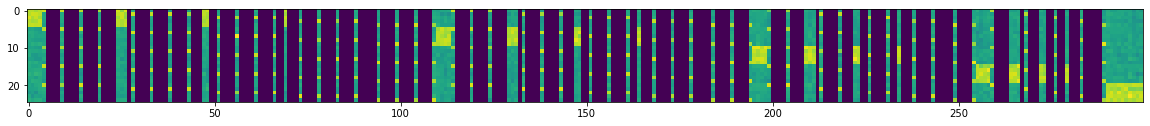

In [48]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

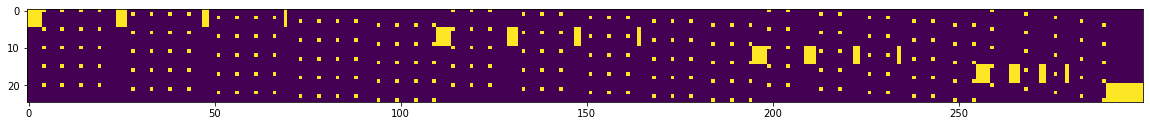

In [49]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

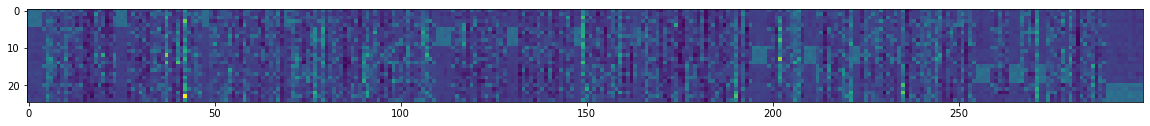

In [50]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

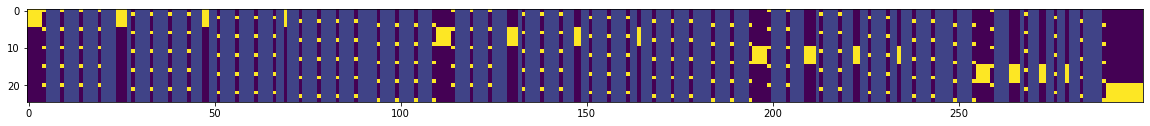

In [51]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3px6erv5') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3px6erv5') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])